In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import time

IMG_HEIGHT = 128
IMG_WIDTH = 224
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
DATA_DIR = '../vimeo_triplet' # Path to the dataset
TRAIN_LIST = os.path.join(DATA_DIR, 'tri_trainlist.txt')
TEST_LIST = os.path.join(DATA_DIR, 'tri_testlist.txt')

In [8]:
def load_and_preprocess_image(path):
    """Loads and preprocesses a single image."""
    image = tf.io.read_file(path)
    # The Vimeo-90K dataset uses PNG format
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # The images are already 256x448, but resizing is good practice
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    return image

def load_triplet(path_suffix):
    """
    Loads the triplet of frames (frame1, frame3 as input; frame2 as target)
    based on the path suffix from the list file (e.g., '00001/0001').
    """
    # The path suffix is a byte string, decode it to a Python string
    path_suffix_str = path_suffix.numpy().decode('utf-8')
    
    # Construct full paths to the three images
    base_path = os.path.join(DATA_DIR, 'sequences', path_suffix_str)
    path1 = os.path.join(base_path, 'im1.png')
    path2 = os.path.join(base_path, 'im2.png')
    path3 = os.path.join(base_path, 'im3.png')

    frame1 = load_and_preprocess_image(path1)
    frame2_target = load_and_preprocess_image(path2) # The middle frame is the target
    frame3 = load_and_preprocess_image(path3)

    # Stack the first and third frames along the channel dimension for the model input
    input_frames = tf.concat([frame1, frame3], axis=-1)
    
    return input_frames, frame2_target

def create_dataset(list_file_path):
    """Creates a tf.data.Dataset from a list file."""
    with open(list_file_path, 'r') as f:
        path_suffixes = [line.strip() for line in f.readlines()]

    dataset = tf.data.Dataset.from_tensor_slices(path_suffixes[:80])
    
    # Use tf.py_function to wrap the Python-based path joining logic
    dataset = dataset.map(lambda x: tf.py_function(load_triplet, [x], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.AUTOTUNE)

    # Configure the dataset for performance
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Create the training dataset
train_dataset = create_dataset(TRAIN_LIST)
print(f"Training dataset created successfully with {len(train_dataset)} batches.")

Training dataset created successfully with 10 batches.


In [9]:
def build_encoder_decoder():
    """Builds a U-Net style encoder-decoder model."""
    # Input takes two concatenated images (3+3=6 channels)
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 6])

    # --- Encoder (Downsampling) ---
    e1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    e1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(e1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(e1)

    e2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(p1)
    e2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(e2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(e2)

    e3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(p2)
    e3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(e3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(e3)

    # --- Bottleneck ---
    b = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p3)
    b = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(b)

    # --- Decoder (Upsampling) with Skip Connections ---
    d3 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b)
    d3 = tf.keras.layers.concatenate([d3, e3]) # Skip connection
    d3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(d3)
    d3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(d3)

    d2 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d3)
    d2 = tf.keras.layers.concatenate([d2, e2]) # Skip connection
    d2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(d2)
    d2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(d2)

    d1 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    d1 = tf.keras.layers.concatenate([d1, e1]) # Skip connection
    d1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(d1)
    d1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(d1)
    
    # Output layer with 3 channels (RGB) and sigmoid activation for [0, 1] range
    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(d1)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the model
model = build_encoder_decoder()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 224,  │      3,520 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 224,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 112,   │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 112,   │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 112,   │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 56,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 56,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 56,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 28,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 28,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 28,    │  2,359,808 │ conv2d_21[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 32, 56,    │    524,544 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 56,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 56,    │  1,179,904 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 56,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 112,   │    131,200 │ conv2d_24[0][0] 

 Total params: 7,699,203 (29.37 MB)

 Trainable params: 7,699,203 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Create an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

def ssim_loss(y_true, y_pred):
    """Computes the SSIM loss."""
    # tf.image.ssim returns a similarity score in [0, 1]
    # The loss is 1 - similarity
    return 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def l1_loss(y_true, y_pred):
    """Computes the Mean Absolute Error loss (L1)."""
    mae = tf.keras.losses.MeanAbsoluteError()
    return mae(y_true, y_pred)

def mse_loss(y_true, y_pred):
    """Computes the Mean Squared Error loss."""
    mse = tf.keras.losses.MeanSquaredError()
    return mse(y_true, y_pred)

def combined_loss(y_true, y_pred, ssim_weight=0.85):
    """
    Computes the combined loss: (ssim_weight * ssim_loss) + ((1 - ssim_weight) * l1_loss).
    """
    s_loss = ssim_loss(y_true, y_pred)
    m_loss = mse_loss(y_true, y_pred)
    l_loss = l1_loss(y_true, y_pred)
    return (ssim_weight * s_loss) + ((1 - ssim_weight) * l_loss)

In [22]:
# Use tf.function to compile the training step for a significant speedup
@tf.function
def train_step(input_frames, target_frame):
    with tf.GradientTape() as tape:
        # 1. Get the model's prediction
        predicted_frame = model(input_frames, training=True)
        
        # 2. Calculate the losses
        total_loss = combined_loss(target_frame, predicted_frame)
        s_loss = ssim_loss(target_frame, predicted_frame)
        m_loss = mse_loss(target_frame, predicted_frame)

    # 3. Calculate gradients
    gradients = tape.gradient(total_loss, model.trainable_variables)
    
    # 4. Apply gradients to update weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return m_loss, s_loss

def train_model(dataset, epochs):
    """The main training function."""
    print("Starting training...")
    for epoch in range(epochs):
        start_time = time.time()
        
        # Metrics to track the average loss for the epoch
        epoch_mse_loss = tf.keras.metrics.Mean()
        epoch_ssim_loss = tf.keras.metrics.Mean()

        for batch_num, (input_batch, target_batch) in enumerate(dataset):
            # Ensure the shapes are correctly set for the model
            input_batch.set_shape([None, IMG_HEIGHT, IMG_WIDTH, 6])
            target_batch.set_shape([None, IMG_HEIGHT, IMG_WIDTH, 3])
            
            # Perform a single training step
            mse, ssim = train_step(input_batch, target_batch)
            
            # Update epoch metrics
            epoch_mse_loss.update_state(mse)
            epoch_ssim_loss.update_state(ssim)
            
            print(f"Batch {batch_num}/{len(dataset)} processed...", end='\r')
        
        end_time = time.time()
        epoch_time = end_time - start_time
        
        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Time: {epoch_time:.2f}s - "
            f"MSE Loss: {epoch_mse_loss.result():.4f} - "
            f"SSIM Loss: {epoch_ssim_loss.result():.4f}"
        )
        
        # Optional: Save the model after each epoch
        model.save_weights(f'./checkpoints/epoch_{epoch+1}.weights.h5')

    print("✅ Training complete!")

In [27]:
train_model(train_dataset, epochs=EPOCHS)

Starting training...
Epoch 1/20 - Time: 41.96s - MSE Loss: 0.0035 - SSIM Loss: 0.1499


KeyboardInterrupt: 

In [24]:
MODEL_WEIGHTS_PATH = './checkpoints/epoch_20.weights.h5'

In [14]:
def get_test_triplet(path_suffix):
    """Loads a single triplet of frames for testing."""
    base_path = os.path.join(DATA_DIR, 'sequences', path_suffix)
    frame1 = load_and_preprocess_image(os.path.join(base_path, 'im1.png'))
    frame_gt = load_and_preprocess_image(os.path.join(base_path, 'im2.png'))
    frame3 = load_and_preprocess_image(os.path.join(base_path, 'im3.png'))
    return frame1, frame3, frame_gt

def display_results(frame1, frame3, ground_truth, predicted_frame, path_suffix):
    """Displays the input, predicted, and ground truth frames."""
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"Sample: {path_suffix}", fontsize=16)

    titles = ["Input Frame 1", "Model Prediction", "Ground Truth (Actual)", "Input Frame 3"]
    images = [frame1, predicted_frame, ground_truth, frame3]

    for i, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    
    plt.show()

In [25]:
model.load_weights(MODEL_WEIGHTS_PATH)

In [16]:
with open(TEST_LIST, 'r') as f:
    test_paths = [line.strip() for line in f.readlines()]
    test_paths = test_paths[:80]


Displaying results for 5 random test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


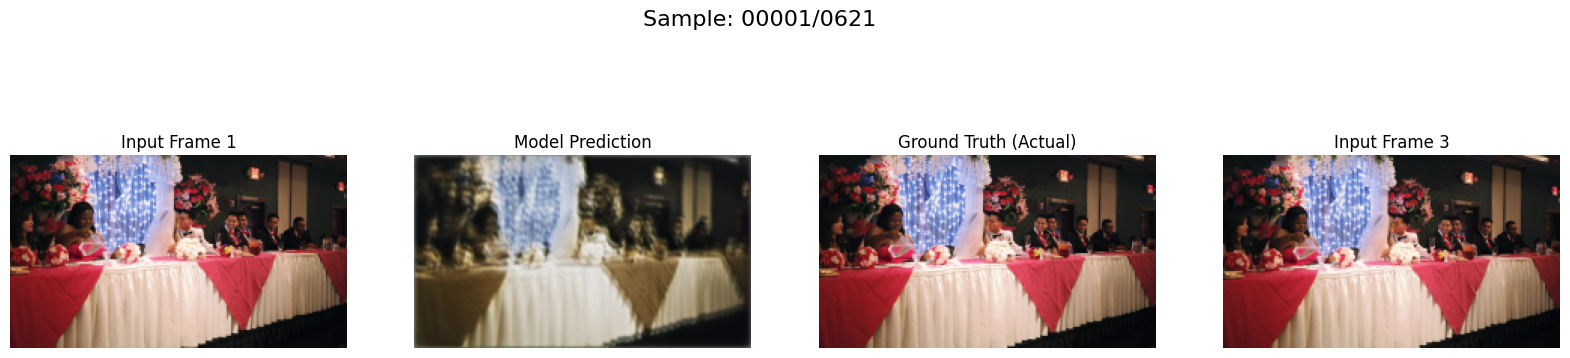

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


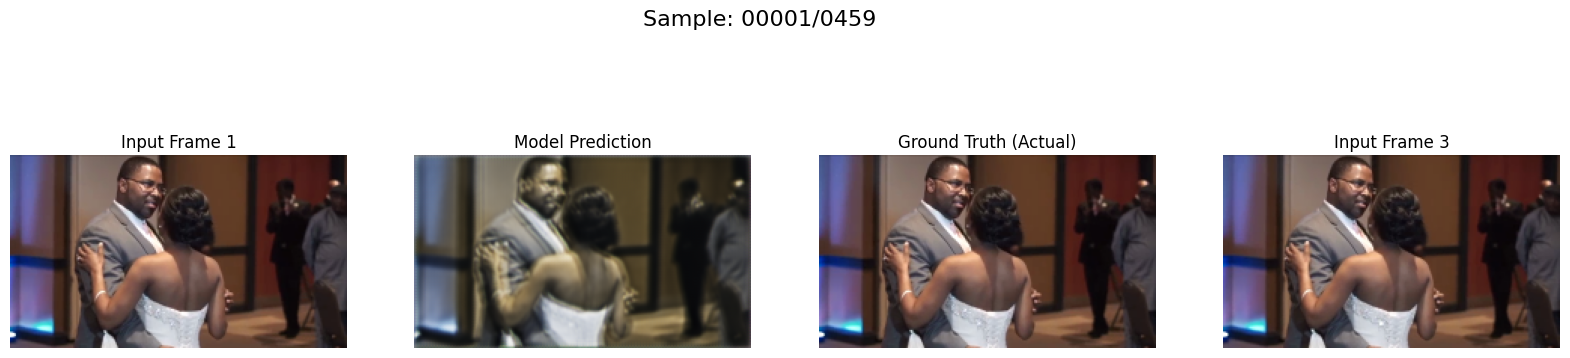

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


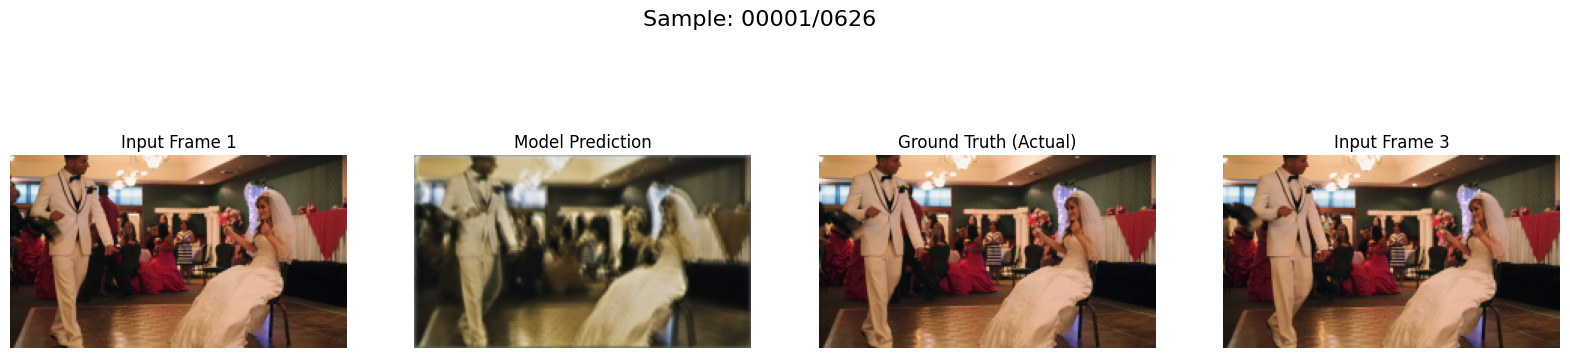

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


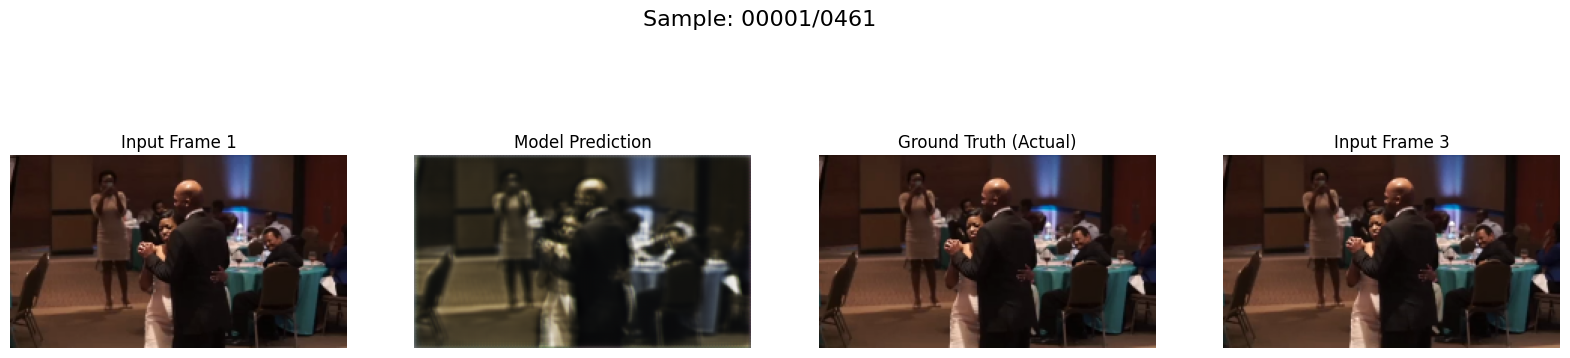

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


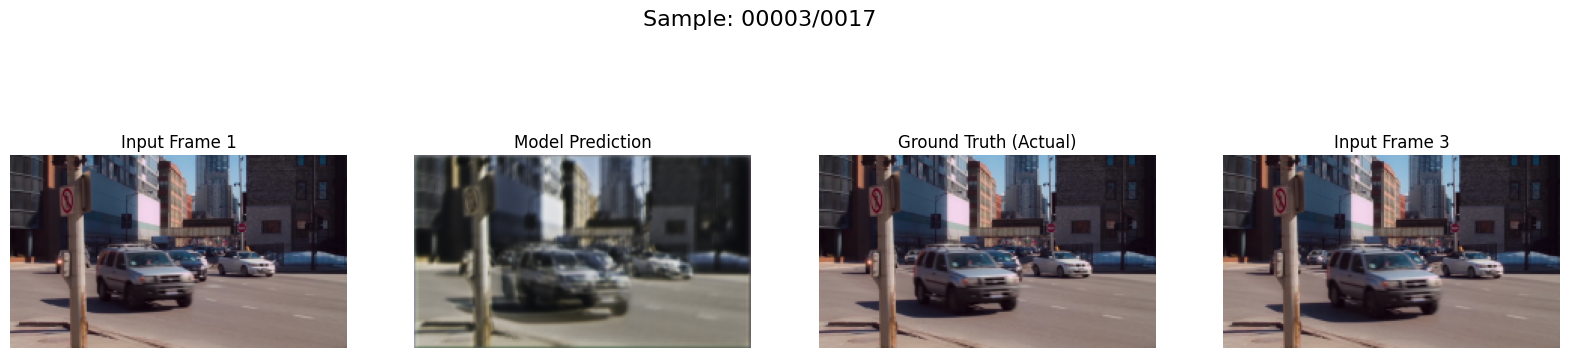

In [19]:
num_samples_to_show = min(5, len(test_paths))
random_samples = random.sample(test_paths, num_samples_to_show)
print(f"\nDisplaying results for {num_samples_to_show} random test samples...")

for path_suffix in random_samples:
    f1, f3, ground_truth = get_test_triplet(path_suffix)
        
    model_input = tf.expand_dims(tf.concat([f1, f3], axis=-1), axis=0)
    predicted_frame = model.predict(model_input)[0]
        
    display_results(f1, f3, ground_truth, predicted_frame, path_suffix)


Displaying results for 5 random test samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


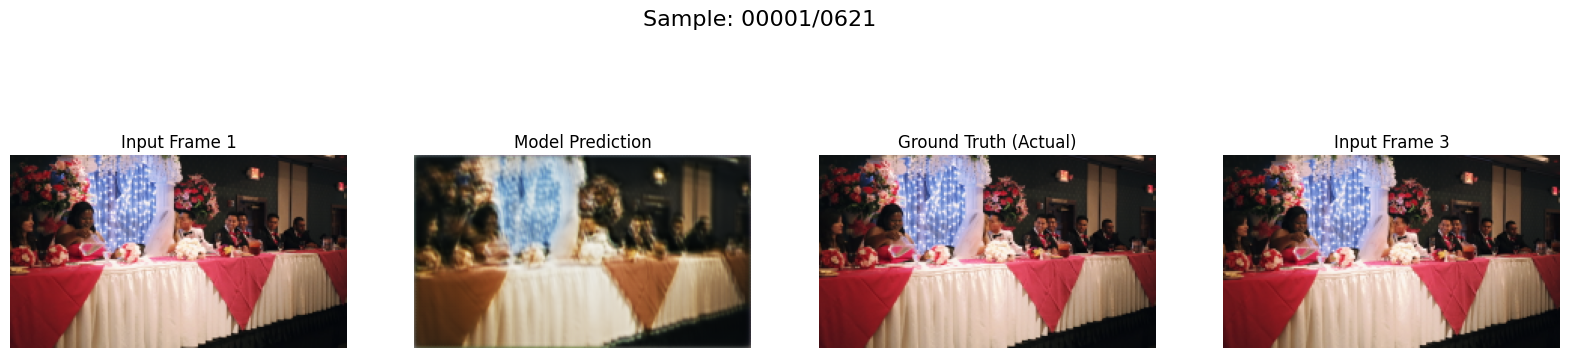

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


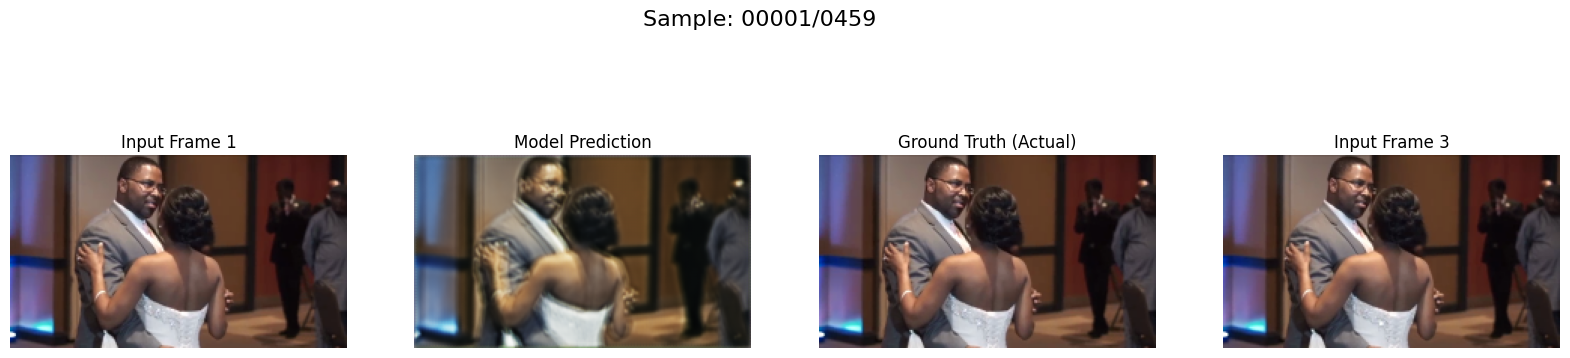

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


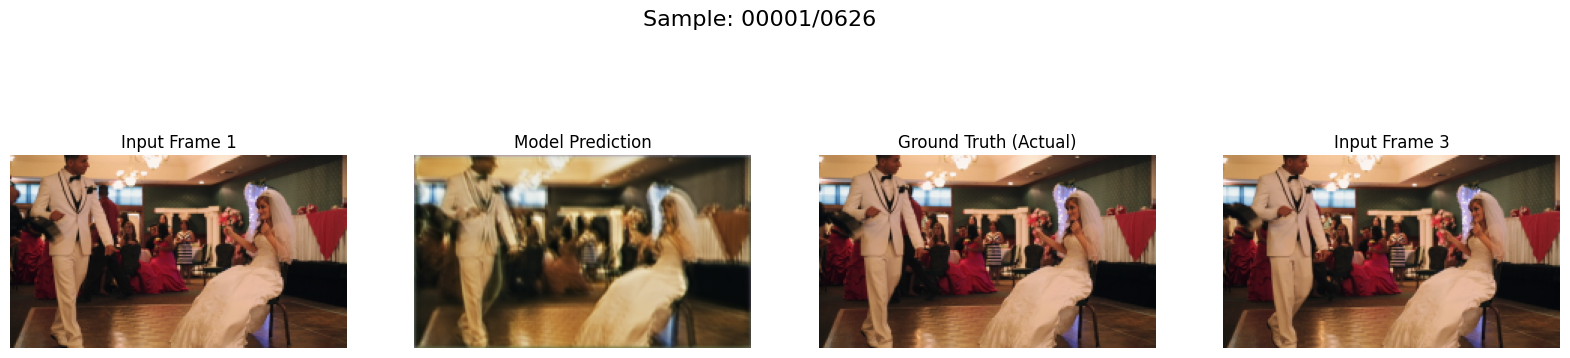

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


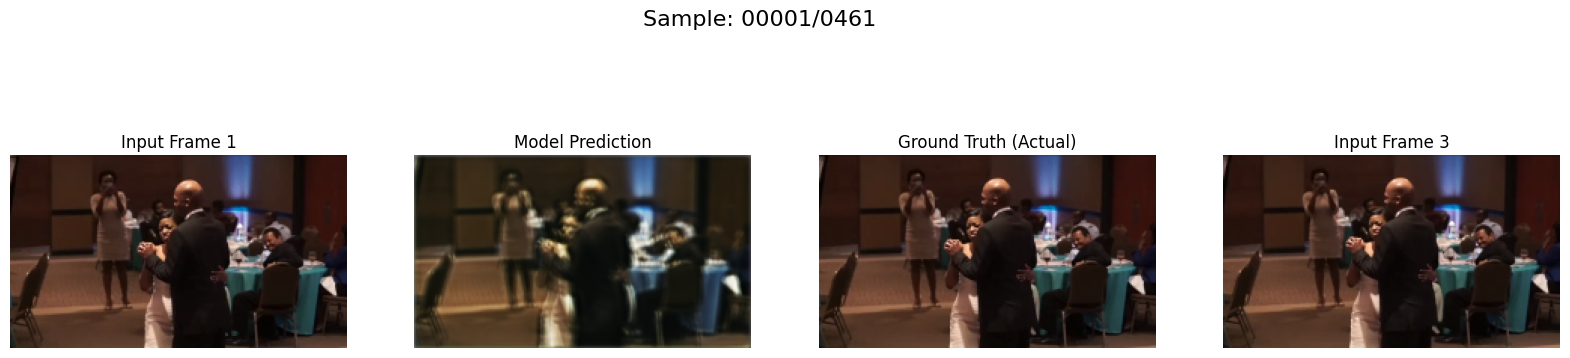

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


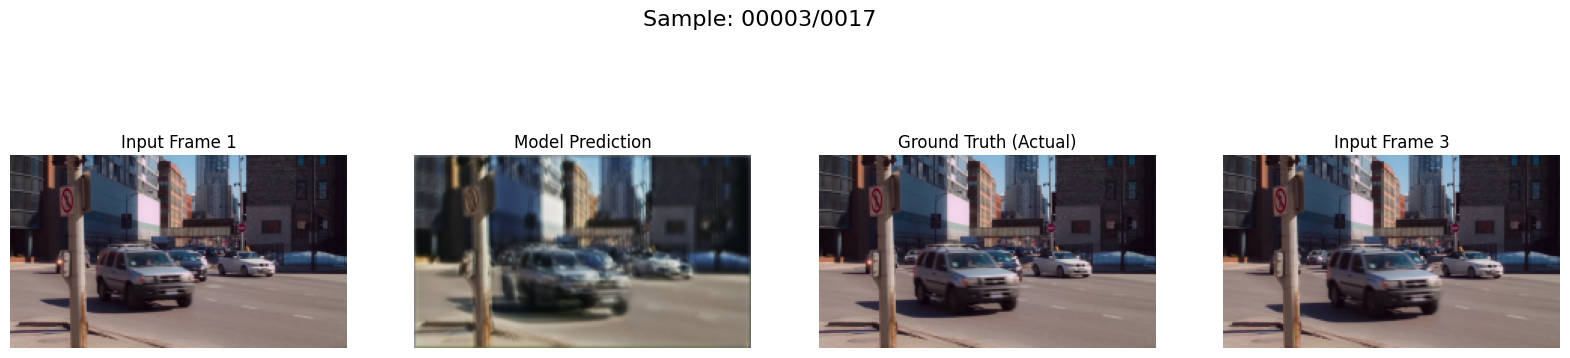

In [26]:
print(f"\nDisplaying results for {num_samples_to_show} random test samples...")

for path_suffix in random_samples:
    f1, f3, ground_truth = get_test_triplet(path_suffix)
        
    model_input = tf.expand_dims(tf.concat([f1, f3], axis=-1), axis=0)
    predicted_frame = model.predict(model_input)[0]
        
    display_results(f1, f3, ground_truth, predicted_frame, path_suffix)